# Clustering Neighborhoods in Hamburg

![texte](http://incentiveandmotivation.com/wp-content/uploads/2019/02/Hamburg-1600x822.jpg)

## Summary

The aim of this project is to examined city of Hamburg and explore venues around metro stations. After gathering all nassesery data we take a look on different neighborhoods. Data has been devided using K-means clustering into tree clusters. In total, fours clusters were identified. Two of clusters are more common and two are unique. However, when it comes to the most common categories of venues, all the clusters look similar to each other, indicating that Hamburg is quite homogeneous in terms of available venue categories.

## 1. Introduction

   The Hamburg U-Bahn is a rapid transit system serving the cities of Hamburg, Norderstedt and Ahrensburg in Germany. Although technically an underground, most of the system's track length is above ground. The network is interconnected with the city's S-Bahn system, which also has underground sections. With Metro System is easier and faster to get to other parts of the city. Many people looks for their flats situated next to metro. At the same time they want to live close to shops, restaurants, coffeshops or parks.
   
The company specializing in long-term as well as short-term aparments renting wants to obtain deeper knowlage about city to build housing recommendation system based on clients preferences. There is a lot of recommendation systems on the market now, but while doing reaserch on Germany market we found out that there is none designed for meeting all needs in one place. People looking for housing needs to search among lots of websites to gain information they need. Different people can have their specific preferences such as favourite stores, shopping location etc. In my project I want to analyze different neighboorhoods of Hamburg which will help to build final recommendation system in the future.


## 2. Data 

### 2.1. Data needed for analysis


For the project its needed to obtain:

* geo-locational information about metro stations in Hamburg -  latitude and longitude of every station. Informations will be obtain based on names of stations. Data will be scrapped from wikipedia page: https://en.wikipedia.org/wiki/List_of_Hamburg_U-Bahn_stations and geo-location information will be added using geopy library.
* Forsqure API will be used to find location information about venues. Explore function will be used to get the most common venues categories next to each metro station like restaurants, art galeries, shops.


After collecting data some visualization and statystical analysis will be made. Location of stations will be shown on map prepered with folium library.  As the next step this data will help to group metro neighborhoods in clusters. Thanks to collected data we will be able to compare neighborhoods and find differences between them which will help rental company to personalize they offer.



### 2.2. Data preparation

#### As a first step all nessesary libraries were imported:

In [1]:
# Importing libraries

# Data manipulation 
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import itertools

# Data-gathering 
from bs4 import BeautifulSoup
import lxml
import json
import requests

# Data visualization 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as cls
import seaborn as sns

# Geospacial tools
import folium
from geopy.geocoders import Nominatim

#additional librariess
from progressbar import ProgressBar
from time import sleep

#k-means from clustering stage
from sklearn.cluster import KMeans

#### Data used in analysis are gathered from wikipedia page with use of BeautifulSoup library:

In [2]:
website_url=requests.get('https://en.wikipedia.org/wiki/List_of_Hamburg_U-Bahn_stations').text

In [3]:
soup = BeautifulSoup(website_url,'lxml')
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of Hamburg U-Bahn stations - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"Xpvb-ApAIIIAA4W0t00AAAAQ","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_Hamburg_U-Bahn_stations","wgTitle":"List of Hamburg U-Bahn stations","wgCurRevisionId":943005601,"wgRevisionId":943005601,"wgArticleId":22088485,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["CS1 German-language sources (de)","Articles with short description","Commons category link is on Wikidata","

In [4]:

data = []
columns = []

My_table = soup.find('table',{'class':'wikitable sortable'})

for index, tr in enumerate(My_table.find_all('tr')):
    section = []
    for td in tr.find_all(['th','td']):
        section.append(td.text.rstrip('\n'))
    
#First row as header
    if (index == 0):
        columns = section
    else:
        data.append(section)
        
#converting to Pandas DataFrame
df_hamburg = pd.DataFrame(data = data,columns = columns)

#change in header
df_hamburg = df_hamburg.rename(columns = {'Line(s)[B]':'Lines'})

df_hamburg = df_hamburg.drop(columns = {"Location[C]", "Fare zone(s)", "Other connections[D]", "Date opened"})

df_hamburg.head(10)

,Station,Lines,Fare zone ring(s)
0,Ahrensburg Ost,U1,B
1,Ahrensburg West,U1,B
2,Alsterdorf,U1,A
3,Alter Teichweg,U1,A
4,Barmbek,U3,A
5,Baumwall,U3,A
6,Berliner Tor,"U2, U3",A
7,Berne,U1,B
8,Billstedt,U2,A
9,Borgweg,U3,A


In [5]:
df_hamburg['Station']

0            Ahrensburg Ost
1           Ahrensburg West
2                Alsterdorf
3            Alter Teichweg
4                   Barmbek
              ...          
87           Wandsbek Markt
88      Wandsbeker Chaussee
89                 Wartenau
90          Überseequartier
91    HafenCity Universität
Name: Station, Length: 92, dtype: object

#### Hamburg_locations dataframe contains 92 metro stations:

In [6]:
hamburg_locations = df_hamburg[['Station']]
hamburg_locations = hamburg_locations.drop_duplicates(subset='Station')
hamburg_locations = hamburg_locations.reset_index(drop=True)
print(hamburg_locations.shape)
hamburg_locations.head()

(92, 1)


,Station
0,Ahrensburg Ost
1,Ahrensburg West
2,Alsterdorf
3,Alter Teichweg
4,Barmbek


#### In next step hamburg_locations dataframe will be complemented with latitude and longitude data:

In [7]:
hamburg_locations['Latitude'] = np.nan
hamburg_locations['Longitude'] = np.nan
hamburg_locations.head()

,Station,Latitude,Longitude
0,Ahrensburg Ost,NaN,NaN
1,Ahrensburg West,NaN,NaN
2,Alsterdorf,NaN,NaN
3,Alter Teichweg,NaN,NaN
4,Barmbek,NaN,NaN


In [8]:
pbar = ProgressBar()
geolocator = Nominatim()
for index in pbar(range(0,hamburg_locations['Station'].shape[0])):
    address = hamburg_locations.loc[index,'Station'] + ", Germany"
    location = geolocator.geocode(address, timeout = None)
    if (location != None):
        hamburg_locations.loc[index,'Latitude'] = location.latitude
        hamburg_locations.loc[index,'Longitude'] = location.longitude
    sleep(1)

print(hamburg_locations.shape)
hamburg_locations.head()

C:\Users\martawa\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  
C:\Users\martawa\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `timeout=None` has been passed to a geocoder call. Using default geocoder timeout. In geopy 2.0 the behavior will be different: None will mean "no timeout" instead of "default geocoder timeout". Pass geopy.geocoders.base.DEFAULT_SENTINEL instead of None to get rid of this warning.
  """


(92, 3)


,Station,Latitude,Longitude
0,Ahrensburg Ost,53.661347,10.242240
1,Ahrensburg West,53.664639,10.219403
2,Alsterdorf,53.610541,10.003889
3,Alter Teichweg,53.586202,10.064931
4,Barmbek,53.587386,10.044942


In [9]:
hamburg_locations.isnull().sum()

Station      0
Latitude     0
Longitude    0
dtype: int64

FOURSQUERE

#### Next step is to define Foursquare credentials:

In [10]:
CLIENT_ID = 'E1UVNEQUN2JFJUUAGEXNKARGIIFEJVTRON50YA0MT5XEA1BJ' # your Foursquare ID
CLIENT_SECRET = 'MNQ0VWBXZJPEHOPVYU0QXCLP53ZFAVVJA5GLBLWGHPZTCOXI' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: E1UVNEQUN2JFJUUAGEXNKARGIIFEJVTRON50YA0MT5XEA1BJ
CLIENT_SECRET:MNQ0VWBXZJPEHOPVYU0QXCLP53ZFAVVJA5GLBLWGHPZTCOXI


#### Defining function that extracts the category of the venue:

In [11]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            print("ERROR: ", url)        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station', 
                  'Station Latitude', 
                  'Station Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
hamburg_venues = getNearbyVenues(names=hamburg_locations['Station'],
                                   latitudes=hamburg_locations['Latitude'],
                                   longitudes=hamburg_locations['Longitude']
                                  )

print(hamburg_venues.shape)
hamburg_venues.head()

Ahrensburg Ost
Ahrensburg West
Alsterdorf
Alter Teichweg
Barmbek
Baumwall
Berliner Tor
Berne
Billstedt
Borgweg
Buchenkamp
Buckhorn
Burgstraße
Christuskirche
Dehnhaide
Emilienstraße
Elbbrücken
Eppendorfer Baum
Farmsen
Feldstraße
Fuhlsbüttel
Fuhlsbüttel Nord
Garstedt
Großhansdorf
Gänsemarkt
Habichtstraße
Hagenbecks Tierpark
Hagendeel
Hallerstraße
Hamburger Straße
Hammer Kirche
Hauptbahnhof Nord
Hauptbahnhof Süd
Hoheluftbrücke
Hoisbüttel
Horner Rennbahn
Hudtwalckerstraße
Joachim-Mähl-Straße
Jungfernstieg
Kellinghusenstraße
Kiekut
Kiwittsmoor
Klein Borstel
Klosterstern
Landungsbrücken
Langenhorn Markt
Langenhorn Nord
Lattenkamp
Legienstraße
Lohmühlenstraße
Lutterothstraße
Lübecker Straße
Meiendorfer Weg
Merkenstraße
Messehallen
Meßberg
Mundsburg
Mönckebergstraße
Mümmelmannsberg
Niendorf Markt
Niendorf Nord
Norderstedt Mitte
Ochsenzoll
Ohlsdorf
Ohlstedt
Osterstraße
Rathaus
Rauhes Haus
Richtweg
Ritterstraße
Rödingsmarkt
Saarlandstraße
Schippelsweg
Schlump
Schmalenbeck
Sengelmannstraße
Sieric

,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ahrensburg Ost,53.661347,10.242240,Ringhotel Ahrensburg,53.661984,10.243314,Hotel
1,Ahrensburg Ost,53.661347,10.242240,U Ahrensburg Ost,53.661227,10.242712,Metro Station
2,Ahrensburg West,53.664639,10.219403,Hansebäckerei Junge,53.663482,10.220533,Bakery
3,Ahrensburg West,53.664639,10.219403,Zum Griechen,53.664910,10.220690,Greek Restaurant
4,Ahrensburg West,53.664639,10.219403,U Ahrensburg West,53.664599,10.220055,Metro Station


#### Thanks to definded function we obtain information about venue categories like Hotels, Bakeries, Restaurants etc.

#### Visualization of metro station situated on map has been shown below:

In [14]:
address = 'Hamburg, Germany'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)

#Insert coordinates in table
latitude = location.latitude
longitude = location.longitude

# create map of Paris using latitude and longitude values
map_hamburg = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, location in zip(hamburg_locations['Latitude'], hamburg_locations['Longitude'], hamburg_locations['Station']):
    label = '{}'.format(location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='navyblue',
        fill=True,
        fill_color='purple',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hamburg)  
    
map_hamburg



#### Analyzing each station neighborhood:

In [15]:
# one hot encoding
hamburg_onehot = pd.get_dummies(hamburg_venues[['Venue Category']], prefix="", prefix_sep="")

# add station column back to dataframe
hamburg_onehot['Station'] = hamburg_venues['Station'] 

# move station column to the first column
fixed_columns = [hamburg_onehot.columns[-1]] + list(hamburg_onehot.columns[:-1])
hamburg_onehot = hamburg_onehot[fixed_columns]

hamburg_onehot.head()

,Station,Accessories Store,American Restaurant,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Trail,Trattoria/Osteria,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Volleyball Court,Whisky Bar,Wine Bar,Wine Shop
0,Ahrensburg Ost,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Ahrensburg Ost,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Ahrensburg West,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Ahrensburg West,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Ahrensburg West,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Grouping rows by Stations and by taking the mean of the frequency of occurrence of each category:

In [16]:
hamburg_grouped = hamburg_onehot.groupby('Station').mean().reset_index()
hamburg_grouped.head()

,Station,Accessories Store,American Restaurant,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Trail,Trattoria/Osteria,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Volleyball Court,Whisky Bar,Wine Bar,Wine Shop
0,Ahrensburg Ost,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,Ahrensburg West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.166667,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
2,Alsterdorf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,Alter Teichweg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.166667,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4,Barmbek,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.023256,...,0.000000,0.023256,0.0,0.023256,0.0,0.023256,0.0,0.0,0.0,0.0


#### Printing each Station along with the top 10 most common venues:

In [17]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [18]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
station_venues_sorted = pd.DataFrame(columns=columns)
station_venues_sorted['Station'] = hamburg_grouped['Station']

for ind in np.arange(hamburg_grouped.shape[0]):
    station_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hamburg_grouped.iloc[ind, :], num_top_venues)

station_venues_sorted.head(10)




,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ahrensburg Ost,Hotel,Metro Station,Creperie,Currywurst Joint,Fountain,Forest,Food Court,Food & Drink Shop,Flower Shop,Flea Market
1,Ahrensburg West,Bakery,Trail,Fast Food Restaurant,Greek Restaurant,Italian Restaurant,Metro Station,Design Studio,Dance Studio,Fountain,Forest
2,Alsterdorf,Bus Stop,Hotel,Pet Store,Asian Restaurant,Bakery,Café,Greek Restaurant,Supermarket,Nature Preserve,Bank
3,Alter Teichweg,Gym / Fitness Center,Athletics & Sports,Bakery,Bus Stop,Supermarket,Metro Station,Thai Restaurant,Doner Restaurant,Convenience Store,Dim Sum Restaurant
4,Barmbek,Bakery,Supermarket,Café,Greek Restaurant,Bar,Drugstore,Bike Rental / Bike Share,Restaurant,Outdoor Supply Store,Canal
5,Baumwall,Portuguese Restaurant,Café,German Restaurant,Italian Restaurant,Seafood Restaurant,Concert Hall,Restaurant,Hotel,Salad Place,Plaza
6,Berliner Tor,Drugstore,Clothing Store,Ice Cream Shop,Bookstore,Gas Station,Multiplex,Building,Department Store,Pedestrian Plaza,Hotel
7,Berne,Bank,Supermarket,Wine Shop,Forest,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant
8,Billstedt,Soccer Field,Flower Shop,German Restaurant,Lighting Store,Bus Stop,Wine Shop,French Restaurant,Forest,Food Court,Food & Drink Shop
9,Borgweg,Café,German Restaurant,Bakery,Doner Restaurant,Metro Station,Tennis Court,Thai Restaurant,Bus Stop,Supermarket,Burger Joint


Among the most common categories of venus we can see:
 - Cafes
 - Bakeries
 - Restaurants
 - Bars
 - Bus Stops
 - Parks

## CLUSTERING

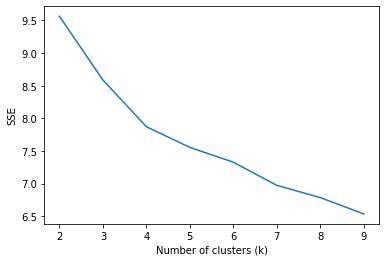

In [33]:
hamburg_clustering = hamburg_grouped.drop('Station', 1)
sse = {}
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=1).fit(hamburg_clustering)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE")
plt.show()

#### Runing *k*-means to cluster the neighborhood into 4 clusters:

In [34]:

# set number of clusters
kclusters = 4

hamburg_clustering = hamburg_grouped.drop('Station', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hamburg_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:4]

array([0, 1, 1, 1])

In [35]:
kmeans.labels_[0:4].dtype


dtype('int32')

#### Creating a new dataframe that includes the cluster as well as the top 10 venues for each Station.

In [36]:
# add clustering labels
station_venues_sorted.insert(0, 'ClusterLabels', kmeans.labels_)
#, int
hamburg_merged = hamburg_locations

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
hamburg_merged = hamburg_merged.join(station_venues_sorted.set_index('Station'), on='Station')

hamburg_merged.tail() # check the last columns!

,Station,Latitude,Longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
87,Wandsbek Markt,53.571664,10.066741,1.0,Drugstore,Asian Restaurant,Bakery,Café,Italian Restaurant,German Restaurant,Clothing Store,Supermarket,Hotel,Turkish Restaurant
88,Wandsbeker Chaussee,53.569667,10.060021,3.0,Supermarket,Hotel,Middle Eastern Restaurant,Turkish Restaurant,Asian Restaurant,Drugstore,Bank,Gym / Fitness Center,German Restaurant,Kebab Restaurant
89,Wartenau,53.564651,10.035408,1.0,Café,Bakery,Hotel,Pharmacy,Supermarket,Wine Shop,Cosmetics Shop,Comic Shop,Nightclub,Chinese Restaurant
90,Überseequartier,53.540424,9.998431,1.0,Italian Restaurant,Hotel,Bakery,Coffee Shop,German Restaurant,Museum,Asian Restaurant,Bar,Seafood Restaurant,Ice Cream Shop
91,HafenCity Universität,53.540554,10.007963,1.0,Art Gallery,Hotel,Theater,Coffee Shop,Museum,Modern European Restaurant,Scenic Lookout,Food Court,Gastropub,Harbor / Marina


In [37]:
hamburg_merged.isnull().sum()
hamburg_merged= hamburg_merged.dropna()

In [38]:
hamburg_merged['ClusterLabels'] =hamburg_merged['ClusterLabels'].astype(int)

#### Vizualization of the resulting clusters:

In [39]:

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10.5)


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [cls.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hamburg_merged['Latitude'], hamburg_merged['Longitude'], hamburg_merged['Station'], hamburg_merged['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-2],
        fill=True,
        fill_color=rainbow[cluster-2],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examining clusters:

In [40]:
hamburg_merged.loc[hamburg_merged['ClusterLabels'] == 0, hamburg_merged.columns[[1] + list(range(5, hamburg_merged.shape[1]))]]

,Latitude,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,53.661347,Arts & Entertainment,Hotel,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Flower Shop
11,53.664363,German Restaurant,Event Service,French Restaurant,Fountain,Forest,Food Court,Food & Drink Shop,Flower Shop,Flea Market
27,53.604340,Metro Station,Event Service,Electronics Store,Fountain,Forest,Food Court,Food & Drink Shop,Flower Shop,Flea Market
40,53.653023,Soccer Field,Italian Restaurant,Metro Station,Fountain,Forest,Food Court,Food & Drink Shop,Event Service,French Restaurant
41,53.674984,Pool,Greek Restaurant,Pub,Event Service,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Eastern European Restaurant
46,53.660976,Ice Cream Shop,Electronics Store,French Restaurant,Fountain,Forest,Food Court,Food & Drink Shop,Flower Shop,Flea Market
52,53.638644,Rock Climbing Spot,Electronics Store,Fountain,Forest,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Fish & Chips Shop
68,53.695772,Metro Station,Hotel Bar,Electronics Store,Fountain,Forest,Food Court,Food & Drink Shop,Flower Shop,Flea Market


In [41]:
hamburg_merged.loc[hamburg_merged['ClusterLabels'] == 1, hamburg_merged.columns[[1] + list(range(5, hamburg_merged.shape[1]))]]

,Latitude,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,53.664639,Bakery,Greek Restaurant,Fast Food Restaurant,Italian Restaurant,Trail,Food & Drink Shop,Flower Shop,Flea Market,Food Court
2,53.610541,Hotel,Pet Store,Asian Restaurant,Bank,Gym / Fitness Center,Salad Place,Café,Greek Restaurant,Supermarket
3,53.586202,Doner Restaurant,Metro Station,Supermarket,Thai Restaurant,Athletics & Sports,Bus Stop,Bakery,Flea Market,Fish & Chips Shop
4,53.587386,Bakery,Drugstore,Bar,Restaurant,Greek Restaurant,Café,Middle Eastern Restaurant,Italian Restaurant,German Restaurant
5,53.544072,Café,German Restaurant,Italian Restaurant,Seafood Restaurant,Hotel,Restaurant,Concert Hall,Hotel Bar,Salad Place
...,...,...,...,...,...,...,...,...,...,...
86,53.592326,Bus Stop,Convenience Store,Volleyball Court,Metro Station,Bank,Falafel Restaurant,Bakery,Event Space,Farmers Market
87,53.571664,Asian Restaurant,Bakery,Café,Italian Restaurant,German Restaurant,Clothing Store,Supermarket,Hotel,Turkish Restaurant
89,53.564651,Bakery,Hotel,Pharmacy,Supermarket,Wine Shop,Cosmetics Shop,Comic Shop,Nightclub,Chinese Restaurant
90,53.540424,Hotel,Bakery,Coffee Shop,German Restaurant,Museum,Asian Restaurant,Bar,Seafood Restaurant,Ice Cream Shop


In [42]:
hamburg_merged.loc[hamburg_merged['ClusterLabels'] == 2, hamburg_merged.columns[[1] + list(range(5, hamburg_merged.shape[1]))]]

,Latitude,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,53.183301,Wine Shop,Event Service,French Restaurant,Fountain,Forest,Food Court,Food & Drink Shop,Flower Shop,Flea Market


In [43]:
hamburg_merged.loc[hamburg_merged['ClusterLabels'] == 3, hamburg_merged.columns[[1] + list(range(5, hamburg_merged.shape[1]))]]

,Latitude,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,53.652958,Shipping Store,Supermarket,Greek Restaurant,Event Service,Fountain,Forest,Food Court,Food & Drink Shop,Flower Shop
12,53.555798,Bakery,Asian Restaurant,Metro Station,Café,Doner Restaurant,Laundromat,Park,Flower Shop,Flea Market
21,53.639252,Indian Restaurant,Supermarket,Breakfast Spot,Wine Shop,Flea Market,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
23,53.663556,Taverna,Italian Restaurant,Metro Station,Bakery,Ice Cream Shop,Pharmacy,Food Court,Food & Drink Shop,Flower Shop
34,53.677703,Pet Store,Metro Station,Snack Place,Food & Drink Shop,Café,Forest,Food Court,Flower Shop,Flea Market
47,54.529794,Pet Store,Drugstore,Auto Garage,Sandwich Place,Big Box Store,Fast Food Restaurant,Falafel Restaurant,Farmers Market,Flea Market
53,53.538636,General Entertainment,Park,Supermarket,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Wine Shop
58,53.528107,Middle Eastern Restaurant,Drugstore,Metro Station,Wine Shop,Event Space,Fountain,Forest,Food Court,Food & Drink Shop
60,53.640853,Convenience Store,Italian Restaurant,Drugstore,Bus Stop,Trail,Bakery,Flower Shop,Flea Market,Fish & Chips Shop
72,53.635296,Drugstore,Insurance Office,Hardware Store,Greek Restaurant,Italian Restaurant,Flea Market,Flower Shop,Fish & Chips Shop,Electronics Store


## 4. Results

During the analysis, several important statistical features of the boroughs were explored and visualized. Becasue of not so big data set we have 4 clusters. We can see that some clusters are more common and some are unique. 
We can see differences from areas closer to city center and other districts - in city center we can find bigger variety of different categories. However, all the clusters look similar to each other, indicating that Hamburg is quite homogeneous in terms of available venue categories.


## 5. Discussion

During analysis of project data I had observation which can be base for futher development.

Like in lots of analytical problems we have to made some assumptions and simplifications to understand and present solution in a better way.Analysis was performed on limited data. If more data would be avaliable our results could be more detailt. If data about prices in different neighborhoods would be provided we could already make some recommendation. For now we can just assume that centrum of the city is more expensive because of a lot of different businesses around. In center of the city we have more more choice and variety of venues.

Forsquere is a good sourse of data, but to performe more detailt analysis we need premium account.


## 6. Conclusion

Although all of the goals of the project were met there is still a huge potential to improve this reaserch. As a next step its possible to develope recommendation system which will help people to get accomodation they dream about. 